#  VAR Model

In [70]:
#Import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from pmdarima.model_selection import train_test_split
warnings.filterwarnings('ignore') 

In [71]:
#Import the dataset and drop NAN values
dvar = pd.read_csv("../Data/clean_data/weekly_data.csv")
dvar = dvar.dropna()

In [72]:
# convert DateTime column into datetime format
dvar["datetime"] = pd.to_datetime(dvar['datetime'])
# set DateTime as index
dvar.set_index("datetime", inplace=True)
dvar.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 412 entries, 2012-01-15 to 2019-12-01
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   suction_tension (20cm)   412 non-null    float64
 1   suction_tension (40cm)   412 non-null    float64
 2   suction_tension (70cm)   412 non-null    float64
 3   water_temperature        412 non-null    float64
 4   barometric_pressure_qfe  412 non-null    float64
 5   dew_point                412 non-null    float64
 6   water_level              412 non-null    float64
 7   inflow_linth (m3/s)      412 non-null    float64
 8   outflow_limmat (m3/s)    412 non-null    float64
 9   precipitation (mm)       412 non-null    float64
 10  Evapotranspiration (mm)  412 non-null    float64
 11  change_rate              412 non-null    float64
dtypes: float64(12)
memory usage: 41.8 KB


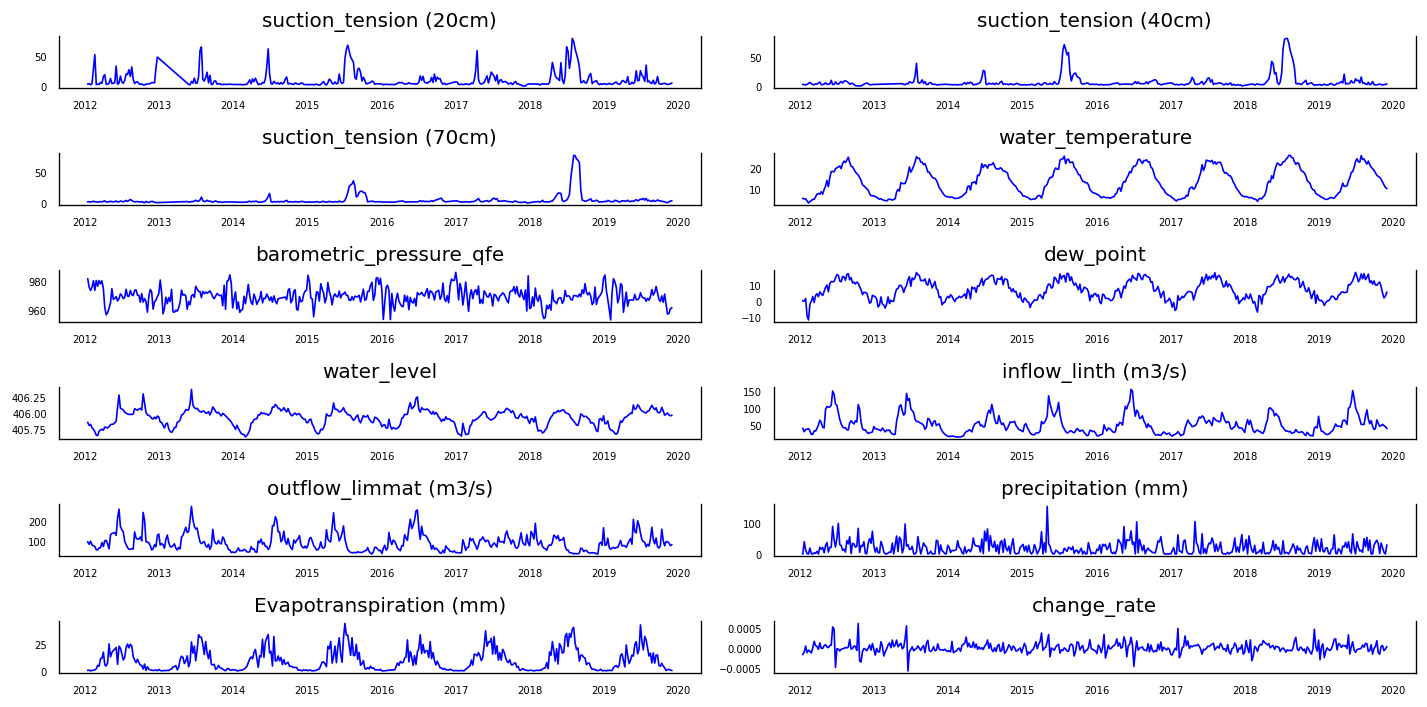

In [73]:
#Plot all variables
fig, axes = plt.subplots(nrows=6, ncols=2, dpi=120, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    data2 = dvar[dvar.columns[i]]
    ax.plot(data2, color='blue', linewidth=1)
    # Decorations
    ax.set_title(dvar.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

Through the plots we could hypothesize that there is some seasonality. One way to verify it, is through the Augmented Dickey-Fuller (ADF) test.

In [74]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

In [75]:
for name, column in dvar.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "suction_tension (20cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.7781
 No. Lags Chosen       = 4
 Critical value 1%     = -3.447
 Critical value 5%     = -2.869
 Critical value 10%    = -2.571
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "suction_tension (40cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.4793
 No. Lags Chosen       = 6
 Critical value 1%     = -3.447
 Critical value 5%     = -2.869
 Critical value 10%    = -2.571
 => P-Value = 0.0002. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "suction_tension (70cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has 

The ADF test states that all variables are stationary. However, since the ACF dropped to zero very slowly, we decide to reject the hypothesys that our data is not stationary and we difference it.

In [85]:
dvar_differenced = dvar.diff()
dvar_differenced = dvar_differenced.dropna()

Split the data into train, validation and test set.

In [180]:
train_differenced, test_differenced = train_test_split(dvar_differenced, train_size=364)

In [184]:
train_val_differenced, val_differenced = train_test_split(train_differenced, train_size=312)

In [198]:
train, test = train_test_split(dvar, train_size=364)
train_val, val = train_test_split(train, train_size=312)
train_val

,suction_tension (20cm),suction_tension (40cm),suction_tension (70cm),water_temperature,barometric_pressure_qfe,dew_point,water_level,inflow_linth (m3/s),outflow_limmat (m3/s),precipitation (mm),Evapotranspiration (mm),change_rate
datetime,,,,,,,,,,,,
2012-01-15,3.045833,2.662500,2.254167,5.230734,981.800595,-0.039742,405.856155,41.259768,97.885887,0.0,0.72,-0.000172
2012-01-22,3.732738,2.593155,2.293155,4.960377,975.973750,-0.223948,405.811720,31.684387,85.611571,40.1,0.89,-0.000109
2012-01-29,1.999405,1.724405,1.831548,5.042589,973.659752,1.402569,405.828179,38.195262,101.169554,13.7,0.19,0.000041
2012-02-05,3.800000,2.969048,2.390476,4.035357,975.891310,-9.414226,405.776389,38.501393,81.974750,1.0,0.70,-0.000128
2012-02-12,27.794643,4.252679,2.889286,3.024345,980.527917,-12.032123,405.751361,40.779726,78.217399,0.0,0.80,-0.000062
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-03,0.014435,1.451346,1.758835,8.382440,967.229960,-1.762599,405.938730,42.358827,85.635518,5.4,1.66,-0.000010
2017-12-10,0.007440,1.825900,1.818018,7.389425,974.117421,-0.273214,405.924194,42.939286,81.690214,35.2,0.83,-0.000036
2017-12-17,2.156945,0.129148,0.612585,6.544246,959.237302,0.433929,405.952966,42.199839,134.293607,63.5,0.94,0.000071


In [109]:
train_val_differenced = train_val_differenced
from statsmodels.tsa.vector_ar.var_model import VAR # imports VAR
model_ohlcwp = VAR(train_val_differenced) # initializes VAR object
model_ohlcwp.select_order(maxlags=10).summary()

,AIC,BIC,FPE,HQIC
0,9.226,9.374,1.016e+04,9.285
1,-7.185,-5.269*,0.0007580,-6.419*
2,-7.735,-4.049,0.0004391,-6.261
3,-7.972*,-2.517,0.0003501*,-5.789
4,-7.939,-0.7143,0.0003693,-5.048
5,-7.766,1.228,0.0004536,-4.167
6,-7.597,3.165,0.0005642,-3.291
7,-7.591,4.941,0.0006092,-2.576
8,-7.677,6.624,0.0006146,-1.955
9,-7.789,8.281,0.0006234,-1.359


From the results, we can see that the lowest AIC is obtained when the lag order is equal to 3.

In [185]:
# creating a walk forward fuction that will split a time series into training and testing set, and return a tuple of the test set 
# and the predicited test set
def walk_forward_VAR(train, test, lag_order):
 
    # makes a list of lists from the train set
    history = [list(x) for x in np.array(train)] 
    forecasts = [] # empty list to store our forecasts
    
    for t in range(test.shape[0]): # for each test set,
        # initialize a VAR model on the train set,
        model = VAR(np.array(history)) 
        model_fit = model.fit(lag_order) # fits the model
        
        # forecast just the next time step
        yhat = model_fit.forecast(model.y, steps=1)
        
        # add the forecast to the forecasts list
        forecasts.append(list(yhat[0])) 
        
        # add the actual test value as the last observation of the 
        # train set
        history.append(list(np.array(test)[t])) 
            
    # return a tuple of the test set and the predicited test set as
    # a tuple of dataframes 
    return test, pd.DataFrame(np.array(forecasts), index=test.index, columns=dvar.columns)

In [186]:
VAR_test_diff, VAR_forecast_diff = walk_forward_VAR(train_val_differenced, val_differenced, 3)

In [187]:
def invert_transformation(data, data_diff, first_diff=False): #first diff? or second diff?
    data1 = data_diff.copy()
    columns = data.columns
    for col in columns:        
        data1[col]= data[col].iloc[-1] + data1[col].cumsum()
    return data1

In [195]:
train_validation_inverted = invert_transformation(val, VAR_test_diff, first_diff=True)

In [205]:
validation_inverted = invert_transformation(train_val, VAR_forecast_diff, first_diff=True)

<AxesSubplot: xlabel='datetime'>

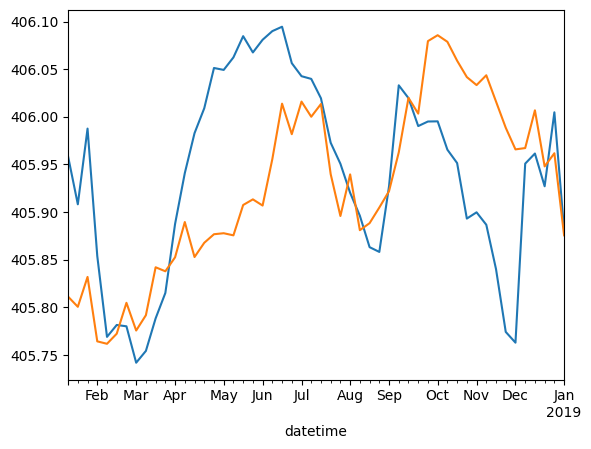

In [206]:
train_validation_inverted["water_level"].plot()
validation_inverted["water_level"].plot()

In [207]:
# defining mean absolute percentage error (MAPE) metric
def mape(df_true, df_pred):
    
    error = df_true - df_pred # calculates the error
    
    return 100 * np.mean(np.abs(error/df_true), axis=0) # resturns the MAPE
 
# importing mean square error
from sklearn.metrics import mean_squared_error as mse

# defining a function to return a dataframe of rmse and mape scores
def get_rmse_and_mape(df_true, df_pred):
    results = {'RMSE': mse(np.array(df_true), np.array(df_pred), multioutput='raw_values', squared=False), 
               'MAPE (%)': mape(np.array(df_true), np.array(df_pred))}
    
    return pd.DataFrame(results, index=df_true.columns)

In [208]:
get_rmse_and_mape(train_validation_inverted, validation_inverted)

,RMSE,MAPE (%)
suction_tension (20cm),61.839138,536.910412
suction_tension (40cm),44.746046,472.254832
suction_tension (70cm),33.045652,346.195347
water_temperature,5.371804,25.768112
barometric_pressure_qfe,36.772797,3.576081
dew_point,4.572674,97.967239
water_level,0.104265,0.020319
inflow_linth (m3/s),45.350684,51.385426
outflow_limmat (m3/s),49.844963,39.201375
precipitation (mm),115.193531,1400.887871
